In [1]:
from hypergraphs import *
from kegg import *
import pandas as pd
import os
import logging

from Bio.KEGG.KGML.KGML_parser import read
import Bio.KEGG.KGML.KGML_pathway
from ast import literal_eval
from urllib.request import urlopen
from urllib.parse import quote_plus
from bs4 import BeautifulSoup
import requests
from Levenshtein import ratio
import scipy.stats
import pathlib
from qf.cc import cardon_crochemore_colored, cardon_crochemore
import random

In [2]:
organismDict = {"hsa": "Homo sapiens (human)"}
outputDirectory = "/Users/boldi/Desktop/pw/"
inputDirectory = "../../LaTeX/Data/KEGG-Pathways/Nov2023/"
dataDirectory = "../../LaTeX/Data/KEGG-Pathways"

In [3]:
pws = pd.read_csv(os.path.join(inputDirectory, "KEGG-pathways.txt"), header=0, 
            names=["Pathway ID", "Pathway type", "Pathway name"], dtype="string", keep_default_na=False)


In [4]:
superpathwayDict = {
    "Involved": [(x,y) for x,y in zip(pws["Pathway ID"], pws["Pathway name"])]
}

In [5]:
superpathway = "Involved"
organism = "hsa"

In [6]:
safeSuperpathway = makesafe(superpathway)

In [7]:
def words2set(words):
    """
        Given a space-separated list of words, returns it as a set of words
    """
    return set(words.split())

In [8]:
from typing import NamedTuple

class Relation(NamedTuple):
    """
        Represents a relation. It is characterized by:
        - a type (e.g. "PPRel") 
        - a list of subtypes (e.g. [('activation', '-->'), ('indirect effect', '..>')])
        - a set of components (source)
        - a list of sets of components (target)
    """
    relType: str
    relSubtypes: list
    source: set
    target: list
    sourceg: Bio.KEGG.KGML.KGML_pathway.Graphics
    targetg: Bio.KEGG.KGML.KGML_pathway.Graphics
        
    @classmethod
    def fromKEGG(cls, relation, pathway):
        """
            Constructor: builds a Relation from a KEGG relation
        """
        if relation.entry2.name == "undefined":
            s = []
            for component in relation.entry2.components:
                s += [words2set(pathway.entries[component.id].name)]
            targetg = pathway.entries[component.id].graphics[0]
        else:
            s = [words2set(relation.entry2.name)]
            targetg = relation.entry2.graphics[0]
        return cls(relation.type, relation.subtypes, words2set(relation.entry1.name), s, targetg, relation.entry1.graphics[0])
        

In [9]:
def relationsFromKEGGpathway(pathway):
    """
        Given a KEGG pathway, returns the list of relations it contains (represented as Relation).
    """
    return [Relation.fromKEGG(r, pathway) for r in pathway.relations]
    

In [10]:
def pathwayFromFile(dataDirectory, organism, pathwayID):
    """
        Load and return a KEGG pathway, given the data directory, the organism specifying the subdirectory,
        and the pathwayID (the filename should be organism+pathwayID+"xml".
    """
    return KGML_parser.read(open(os.path.join(dataDirectory, organism, organism+pathwayID+".xml"), "r"))

In [11]:
def relationsFromFile(dataDirectory, organism, pathwayID):
    """
        Given a pathway file (specified by a root dataDirectory, the name of the organism subdirectory, and the name
        of the file [organism+pathwayID.xml]), reads it and returns the list of its relations.
    """
    pathway = pathwayFromFile(dataDirectory, organism, pathwayID)
    return relationsFromKEGGpathway(pathway)

In [12]:
def relationsForSuperpathway(dataDirectory, organism, superpathwayDict, superpathway):
    """
        Given a superpathDict (whose keys are superpathway names and whose values are list of
        pairs (pathwayID, pathwayName)), reads all the pathway file for a specific superpathway name
        and returns a dictionary whose keys are the pathwayID's and whose values are the list of relations.
    """
    rel = {}
    for k,v in superpathwayDict[superpathway]:
        #logging.info("Reading", k, v)
        rel[k] = relationsFromFile(dataDirectory, organism, k)
    return rel

In [13]:
def subtypes(rel):
    """
        Given a map whose values are relations, accumulate all subtypes appearing and assign them a number.
        The result is a map from subtype string to number.
    """
    all_subtypes = set([])
    for pathwayid, relations in rel.items():
        for relation in relations:
            all_subtypes |= set([str(relation.relSubtypes)])
        
    s = sorted(list(all_subtypes))
    subtype2color = {v:k for k,v in enumerate(s)}

    return subtype2color

In [14]:
def set2can(s):
    """
        Convert a set to a string in a canonical way.
    """
    return str(sorted(list(s)))

def can2set(c):
    """
        Does the converse of set2can.
    """
    return set(literal_eval(c))

In [15]:
def indices(rel):
    """
        Given a map whose values are lists of relations, it considers all the relations one by one, and attributes a unique id 
        to each element (i.e., set of components appearing as source or in the target of some relation) and block (the set of
        element id appearing as target of some relation).
        This function returns the dictionaries to move from/to an element or block to the corresponding id.
        Elements are string representations of sorted lists of strings.
        Blocks are string representations of sorted lists of ints.
    """
    element2id = {}
    id2element = {}
    block2id = {}
    id2block = {}

    for relations in rel.values():
        for relation in relations:
            s = set2can(relation.source)
            if s not in element2id.keys():
                element2id[s] = len(element2id)
            targetset = set([])
            for targ in relation.target:
                t = set2can(targ)
                if t not in element2id.keys():
                    element2id[t] = len(element2id)
                targetset |= set([element2id[t]])
            ts = set2can(targetset)
            if ts not in block2id.keys():
                block2id[ts] = len(block2id)

    for k,v in element2id.items():
        id2element[v] = k
    for k,v in block2id.items():
        id2block[v] = k
    return element2id, id2element, block2id, id2block


In [16]:
def search_gene_KEGG(geneID):
    """
        Search for gene on KEGG. 
        
        Returns list of names.
    """
    url1 = "https://www.kegg.jp/entry/"+geneID
    response1 = requests.get(url1, allow_redirects=False)    
    soup = BeautifulSoup(response1.text, "html.parser")
    tds = [tds for tds in soup.find_all("td", {"class": "td11 defd"})]
    names = tds[0].getText().strip().split(", ")
    return names

In [17]:
# Build all data needed for the relations of the superpathway
rel = relationsForSuperpathway(dataDirectory, organism, superpathwayDict, superpathway)
element2id, id2element, block2id, id2block = indices(rel)
subtype2color = subtypes(rel)
elements = list(set.union(*[can2set(k) for k in element2id.keys()]))

In [18]:
# name2gene is a function mapping names to gene IDs (hsa:xxxx)
# e.g. KCNE3, BRGDA6 etc are all mapped to hsa:10008 (see https://www.kegg.jp/entry/hsa:10008)
# This map was produced by scraping kegg, but this has been done only once.
# After that, we just read a pkl file

name2keggFilename = os.path.join(inputDirectory, "name2kegg.pkl")

if os.path.exists(name2keggFilename):
    print("Reading gene names")
    with open(name2keggFilename, "rb") as handle:
        name2gene = pickle.load(handle)
else:
    print("Producing gene names")
    d = {}
    nelements = len(elements)
    for count,element in enumerate(elements):
        if count % 10 == 0:
            print(f"{count}/{nelements}")
        if element.startswith("hsa"):
            names = search_gene_KEGG(element)
            for name in names:
                d[name] = element
    with open(name2keggFilename, "wb") as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)
    name2gene = d

Reading gene names


In [19]:
# Read patient data
print("Reading patient data")
genes = pd.read_csv(os.path.join(inputDirectory, "genes.csv"))
patients = genes["name"].values.tolist()
classification = pd.read_csv(os.path.join(inputDirectory, "classification.csv"))

patient2class = {patient: classification.loc[classification["name"]==patient]["classification"].values.flatten().tolist()[0] for patient in patients}
numHealthy = sum([x == 'healthy' for x in patient2class.values()])
numDiseased = sum([x == 'diseased' for x in patient2class.values()])

Reading patient data


In [20]:
# Dividing genes into two frames (one for healthy individuals and one for diseased individuals)
genesHealthy = genes.loc[genes["name"].apply(lambda x: patient2class[x])=="healthy"]
genesDiseased = genes.loc[genes["name"].apply(lambda x: patient2class[x])=="diseased"]

In [21]:
# Building the graph of all relations contained in rel values
# Nodes are IDs, and node x correspond to the set of genes (and/or compound) id2element[x]
print("Building the relation graph")
G = nx.DiGraph() 
for relations in rel.values():
    for relation in relations:
        source = element2id[set2can(relation.source)]
        for targ in relation.target:
            target = element2id[set2can(targ)]
            G.add_edge(source, target, color=subtype2color[str(relation.relSubtypes)])
            

# Computing the minimum fibres
cc=cardon_crochemore_colored(G)

colors = list(matplotlib.colors.CSS4_COLORS.values())
usedColors = 0

cc2fibresize = {}
cc2fibre = {}
ccnontrivial = {}
nontrivialclass2col = {}

fibres = []
node2fibre = {}
for v in set(cc.values()):
    fibre = [x for x in G.nodes() if cc[x] == v]
    fibres += [fibre]
    for x in fibre:
        node2fibre[x] = fibre
    cc2fibre[v] = fibre
    cc2fibresize[v] = len(fibre)
    if len(fibre) > 0:
        ccnontrivial[v] = cc[v]
        nontrivialclass2col[v] = colors[usedColors]
        usedColors += 1

Building the relation graph


In [22]:
# Build node2columns, mapping each node of G to the list of genes corresponding to it
# for which we know a value (in the genes dataframe), sorted
#

print("Mapping genes to columns")
namedGenes = set(name2gene.values())     
columns = set(genes.columns.values.tolist()[2:])
node2columns = {}
for node in G.nodes():
    nodeGenes = can2set(id2element[node])
    s = []
    for gene in nodeGenes & namedGenes:
        for k,v in name2gene.items():
            if v == gene:
                if k in columns:
                    s += [k]
    node2columns[node]=sorted(s)

Mapping genes to columns


In [23]:
s = ""
for pair in superpathwayDict[superpathway]:
    pathwayID = pair[0]
    pathway = pathwayFromFile(dataDirectory, organism, pathwayID)
    canvas = KGMLCanvas(pathway)
    for k in pathway.entries:
        name = pathway.entries[k].name
        canonicalName = set2can(words2set(name))
        if canonicalName in element2id.keys():
            node = element2id[canonicalName]
            klass = cc[node]
            if klass in nontrivialclass2col:
                pathway.entries[k].graphics[0].bgcolor = nontrivialclass2col[klass]
                pathway.entries[k].graphics[0].fgcolor = nontrivialclass2col[klass]
            else:
                pathway.entries[k].graphics[0].bgcolor = "#FFFFFF"
                pathway.enries[k].graphics[0].fgcolor = "#FFFFFF"
            s += pathwayID + "\t" + str(node) + "\t" + str(klass) +"\t"+pathway.entries[k].graphics[0].name+"\t"+canonicalName + "\n"
    canvas.import_imagemap = True
    pdfName = organism + pathwayID + ".pdf"
    pathlib.Path(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway)).mkdir(parents=True, exist_ok=True)
    canvas.draw(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway, pdfName))
with open(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway, "all.tsv"), "wt") as file:
    file.write(s)

In [24]:
def columns2nodes(columns, node2columns, ignoreEmpty = True):
    """
        Returns a map from columns to the nodes where the column appears.
    """
    res = {} 
    for c in columns:
        s = set([])
        for no, co in node2columns.items():
            if c in co:
                s |= set([no])
        if len(s) > 0 or not ignoreEmpty:
            res[c] = s
    return res

c2n = columns2nodes(columns, node2columns)
usableColumns = list(c2n.keys())

In [25]:
def areRelated(column1, column2, column2nodes, node2color, inDegThreshold = 0):
    nodes1 = column2nodes[column1]
    nodes2 = column2nodes[column2]
    colors1 = set([node2color[node] for node in nodes1])
    colors2 = set([node2color[node] for node in nodes2])
    commonColors = colors1 & colors2
    if len(commonColors) == 0:
        return False
    maxInDeg = max([G.in_degree(cc2fibre[c][0]) for c in commonColors])
    return maxInDeg >= inDegThreshold

In [79]:
def tauForPair(genes, set1, set2):
    """
        Given a dataframe genes (i.e., a set of patients), and two sets of column names (set1, set2), 
        build the Kendall's tau
        for every pair of columns in set1 and set2 and return the average statistic and its std.
    """
    taus = []
    for gene1 in set1:
        for gene2 in set2:
            expr1 = genes.loc[:,gene1].values.tolist()
            expr2 = genes.loc[:,gene2].values.tolist()
            taus += [scipy.stats.kendalltau(expr1, expr2).statistic]
    return pd.DataFrame(taus).mean().values[0], pd.DataFrame(taus).std().values[0]

In [80]:
def sampleTauForPairDiffsDist(genes, set1, set2, numberOfRows1, numberOfSamples = 100):
    """
        Repeatedly (for numberOfSamples times) do the following:
        - select numberOfRows1 rows of genes, and then compute tauForPair on those rows for set1 and set2
        - do the same for remaining rows
        - take the difference between the two resulting set of taus.
        Return the mean and std of differences.
    """
    diffs = []
    
    for i in range(numberOfSamples):
        genes1 = random.sample(range(len(genes)), numberOfRows1)
        genes2 = list(set(range(len(genes)))-set(genes1))
        mt1, mstd1 = tauForPair(genes.iloc[genes1], set1, set2)
        mt2, mstd2 = tauForPair(genes.iloc[genes2], set1, set2)
        diffs += [mt1-mt2]
    return diffs


def tauForPairDiff(genes1, genes2, set1, set2):
    """
        Compute tauForPair for set1 and set2 over the set of rows genes1 and genes2, and return
        the difference of taus.
    """
    mt1, mstd1 = tauForPair(genes1, set1, set2)
    mt2, mstd2 = tauForPair(genes2, set1, set2)
    return mt1-mt2

In [81]:
outd = {}
for s,t,d in G.edges(data=True):
    subtypeName = [k for k,v in subtype2color.items() if d["color"]==v][0]
    sg = node2columns[s]
    tg = node2columns[t]
    if len(sg) == 0 or len(tg) == 0:
        continue
    taudiff = tauForPairDiff(genesHealthy, genesDiseased, sg, tg)
    tt = sampleTauForPairDiffsDist(genes, sg, tg, numHealthy)
    tauSampleDiff = pd.DataFrame(tt).mean().values[0]
    tauSampleDiffStd = pd.DataFrame(tt).std().values[0]
    if taudiff >= tauSampleDiff - tauSampleDiffStd and taudiff <= tauSampleDiff + tauSampleDiffStd:
        pass#print(sg, tg, taudiff, tauSampleDiff, tauSampleDiffStd,"->NO")
    else:
        outd[f"({s},{t})"] = taudiff
        if taudiff < tauSampleDiff:
            print(f"[{subtypeName}]: ({sg}, {tg}) --- {taudiff} vs. {tauSampleDiff}±{tauSampleDiffStd}->Diseased are significantly more correlated")
        else:
            print(f"[{subtypeName}]: ({sg}, {tg}) --- {taudiff} vs. {tauSampleDiff}±{tauSampleDiffStd}->Healthy are significantly more correlated")

[[('phosphorylation', '+p')]]: (['PAK1', 'PAK4', 'PAK5', 'PAK6'], ['MAP2K1']) --- -0.1533323674297305 vs. 0.024255288322225434±0.13933715409632205->Diseased are significantly more correlated
[[('phosphorylation', '+p')]]: (['RAF1'], ['MAP2K1']) --- -0.444566792234135 vs. -0.0007215299913068884±0.18076883712194708->Diseased are significantly more correlated
[[('inhibition', '--|'), ('phosphorylation', '+p')]]: (['RAF1'], ['BAD']) --- -0.27238481599536357 vs. 0.007866125760649104±0.16362551421237403->Diseased are significantly more correlated
[[('phosphorylation', '+p')]]: (['MAPK1', 'MAPK3'], ['BCL2']) --- -0.1897131266299623 vs. 0.007467400753404837±0.13190435339302747->Diseased are significantly more correlated
[[('activation', '-->'), ('indirect effect', '..>')]]: (['MAPK1', 'MAPK3'], ['PLA2G4A', 'PLA2G4C', 'PLA2G4D', 'PLA2G4E', 'PLA2G4F']) --- 0.08977472756562416 vs. 0.0034779829158909027±0.07347794710741956->Healthy are significantly more correlated
[[('expression', '-->')]]: (['EL

[[('inhibition', '--|')]]: (['CDKN1A'], ['CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2']) --- -0.1583535277073205 vs. -0.0041794800302074045±0.08353359261529537->Diseased are significantly more correlated
[[('inhibition', '--|')]]: (['CDKN1A'], ['CDK2', 'CDK4', 'CDK6']) --- 0.162264893950764 vs. 0.0036717273108048177±0.14510733633386375->Healthy are significantly more correlated
[[('expression', '-->')]]: (['FOXO3'], ['BCL2L11']) --- 0.20347725297015354 vs. 0.001018255578093309±0.18630911363253655->Healthy are significantly more correlated
[[('activation', '-->')]]: (['MTOR'], ['RPS6KB1', 'RPS6KB2']) --- 0.15725876557519558 vs. -0.011964572142013168±0.11009777767693044->Healthy are significantly more correlated
[[('activation', '-->')]]: (['STK11'], ['PRKAA1', 'PRKAA2']) --- 0.35986670530281073 vs. 0.009175682081002542±0.13623688726622707->Healthy are significantly more correlated
[[('activation', '-->')]]: (['PRKG1', 'PRKG2'], ['BST1', 'CD38']) --- 0.1454071283685888 vs. 0.00968617791944

In [82]:
from reportlab.lib.units import inch
import PIL.Image
from io import BytesIO
import reportlab.pdfgen.canvas
import reportlab.lib.colors

def significantTau(tau):
    return abs(tau) > 0.2

def convertTauValue(tau):
    return 3*math.exp(abs(tau)*3)

def convertTauColor(tau):
    if tau < 0:
        return reportlab.lib.colors.red
    else:
        return reportlab.lib.colors.green

#from __future__ import nested_scopes

def get_temp_imagefilename(url):
    """Return filename of temporary file containing downloaded image.

    Create a new temporary file to hold the image file at the passed URL
    and return the filename.
    """
    img = urlopen(url).read()
    im = PIL.Image.open(BytesIO(img))
    # im.transpose(Image.FLIP_TOP_BOTTOM)
    f = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    fname = f.name
    f.close()
    im.save(fname, "PNG")
    return fname


#def enhance_method(klass, method_name, replacement):
#    'replace a method with an enhanced version'
#    method = getattr(klass, method_name)
#    def enhanced(*args, **kwds): return replacement(*args, **kwds)
#    setattr(klass, method_name, enhanced)

def new_draw(self, filename, colrel):
        """Add the map elements to the drawing."""
        # Instantiate the drawing, first
        # size x_max, y_max for now - we can add margins, later
        if self.import_imagemap:
            # We're drawing directly on the image, so we set the canvas to the
            # same size as the image
            if os.path.isfile(self.pathway.image):
                imfilename = self.pathway.image
            else:
                imfilename = get_temp_imagefilename(self.pathway.image)
            im = PIL.Image.open(imfilename)
            cwidth, cheight = im.size
        else:
            # No image, so we set the canvas size to accommodate visible
            # elements
            cwidth, cheight = (self.pathway.bounds[1][0], self.pathway.bounds[1][1])
        # Instantiate canvas
        self.drawing = reportlab.pdfgen.canvas.Canvas(
            filename,
            bottomup=0,
            pagesize=(
                cwidth * (1 + 2 * self.margins[0]),
                cheight * (1 + 2 * self.margins[1]),
            ),
        )
        self.drawing.setFont(self.fontname, self.fontsize)
        # Transform the canvas to add the margins
        self.drawing.translate(
            self.margins[0] * self.pathway.bounds[1][0],
            self.margins[1] * self.pathway.bounds[1][1],
        )
        # Add the map image, if required
        if self.import_imagemap:
            self.drawing.saveState()
            self.drawing.scale(1, -1)
            self.drawing.translate(0, -cheight)
            self.drawing.drawImage(imfilename, 0, 0)
            self.drawing.restoreState()
        # Add the reactions, compounds and maps
        # Maps go on first, to be overlaid by more information.
        # By default, they're slightly transparent.
        if self.show_maps:
            self.__add_maps()
        if self.show_reaction_entries:
            KGMLCanvas._KGMLCanvas__add_reaction_entries(self)
        if self.show_orthologs:
            KGMLCanvas._KGMLCanvas__add_orthologs(self)
        if self.show_compounds:
            KGMLCanvas._KGMLCanvas__add_compounds(self)
        if self.show_genes:
            KGMLCanvas._KGMLCanvas__add_genes(self)
        # TODO: complete draw_relations code
        # if self.draw_relations:
        #    self.__add_relations()
        # Write the pathway map to PDF
        for sg,tg,width,color in colrel:
            self.drawing.setLineWidth(width)
            self.drawing.setStrokeColor(color)
            self.drawing.line(sg.x,sg.y,tg.x,tg.y)
        self.drawing.save()
        
#enhance_method(KGMLCanvas, 'draw',  new_draw)
setattr(KGMLCanvas, 'new_draw', new_draw)

s = ""
for pair in superpathwayDict[superpathway]:
    pathwayID = pair[0]
    pathway = pathwayFromFile(dataDirectory, organism, pathwayID)
    
    colrel = []
    for relation in rel[pathwayID]:
        source = element2id[set2can(relation.source)]
        for targ in relation.target:
            target = element2id[set2can(targ)]    
            key = "({},{})".format(source,target)
            if key in outd:
                if significantTau(outd[key]):
                    colrel += [(relation.sourceg, relation.targetg, convertTauValue(outd[key]), convertTauColor(outd[key]))]

    canvas = KGMLCanvas(pathway)

    for k in pathway.entries:
        name = pathway.entries[k].name
        canonicalName = set2can(words2set(name))
        if canonicalName in element2id.keys():
            node = element2id[canonicalName]
            klass = cc[node]
            if klass in nontrivialclass2col:
                pathway.entries[k].graphics[0].bgcolor = nontrivialclass2col[klass]
                pathway.entries[k].graphics[0].fgcolor = nontrivialclass2col[klass]
            else:
                pathway.entries[k].graphics[0].bgcolor = "#FFFFFF"
                pathway.enries[k].graphics[0].fgcolor = "#FFFFFF"
            s += pathwayID + "\t" + str(node) + "\t" + str(klass) +"\t"+pathway.entries[k].graphics[0].name+"\t"+canonicalName + "\n"
    
            
    canvas.import_imagemap = True
    pdfName = organism + pathwayID + ".pdf"
    pathlib.Path(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway + "-col")).mkdir(parents=True, exist_ok=True)
    canvas.new_draw(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway+ "-col", pdfName), colrel)
#with open(os.path.join("/Users/boldi/Desktop/", organism, safeSuperpathway + "-col", "all.tsv"), "wt") as file:
#    file.write(s)

In [83]:
t=sampleTauForPairDiffsDist(genes, ['RAF1'], ['MAP2K1'], numHealthy, numberOfSamples = 100)

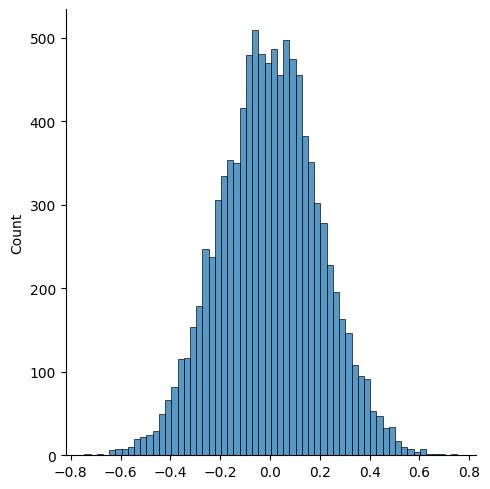

In [60]:
import seaborn as sns
sns.displot(t)

In [61]:
from scipy import stats
res = stats.normaltest(t)

In [62]:
res.statistic

0.9031307461093279

In [63]:
res.pvalue

0.6366308065065713

In [64]:
res = stats.normaltest(np.random.normal(pd.DataFrame(t).mean().values[0], pd.DataFrame(t).std().values[0], 10000))

In [65]:
res.statistic

0.7444207889823913

In [66]:
res.pvalue

0.6892092214454659

In [67]:
tauForPairDiff(genesHealthy, genesDiseased, ['RAF1'], ['MAP2K1'])

-0.444566792234135

In [34]:
len(genes)

64

In [40]:
genes1 = random.sample(range(len(genes)), 3)
genes2 = list(set(range(len(genes)))-set(genes1))

In [41]:
genes.iloc[genes1]

,Unnamed: 0,name,A1BG,ADA,CDH2,AKT3,100008588,100008589,100009676,MED6,...,THOC1,REC8,RCE1,HNRNPDL,DMTF1,PPP4R1,SLC12A6,PTBP3,DGCR2,SCO2
51,51,GSM1574474,5.736730,7.085667,5.395656,5.692972,12.011536,10.206174,6.420234,8.090269,...,6.614601,6.412066,6.002645,6.680613,7.256032,7.579093,5.924431,8.318820,7.352752,8.427214
17,17,GSM1574440,5.906989,7.725843,5.255621,5.431474,11.494311,10.867244,6.153189,8.439548,...,7.079432,6.300575,5.953793,6.929206,7.306660,7.490425,5.373872,8.643313,7.323018,7.888204
61,61,GSM1574484,5.606271,7.757515,5.618650,5.494501,11.678308,11.502444,5.985153,8.202394,...,7.030866,6.064598,5.797958,7.296972,7.784769,7.516425,5.852640,8.801789,6.655766,7.288676


In [42]:
genes.iloc[genes2]

,Unnamed: 0,name,A1BG,ADA,CDH2,AKT3,100008588,100008589,100009676,MED6,...,THOC1,REC8,RCE1,HNRNPDL,DMTF1,PPP4R1,SLC12A6,PTBP3,DGCR2,SCO2
0,0,GSM1574423,5.513040,8.105445,5.538153,5.367775,11.146230,11.589834,5.901013,8.079373,...,7.198096,6.152714,6.291999,7.194089,7.440856,7.791873,5.683778,8.471226,7.106159,7.440375
1,1,GSM1574424,5.238013,7.019328,5.188991,5.401298,11.728307,10.464450,6.265463,8.179442,...,7.045319,6.022443,6.045065,7.297708,7.821551,7.663454,5.675778,8.700451,6.962812,7.005557
2,2,GSM1574425,5.708308,7.230270,5.507846,5.397361,12.047896,11.318551,6.224461,8.074019,...,7.213119,6.178724,5.782921,6.998591,7.510197,7.663987,5.664503,8.643570,7.205886,7.787051
3,3,GSM1574426,5.740369,7.396263,5.442095,5.296547,11.650462,11.303002,6.022263,8.177189,...,7.098039,6.058239,5.673125,7.204400,7.893798,7.376775,5.750436,8.928652,6.890701,7.143114
4,4,GSM1574427,5.932976,7.238479,6.143618,5.671180,11.718869,10.859258,6.023132,8.228727,...,6.648952,6.114541,5.814955,7.399123,7.605499,7.356980,5.543969,8.511676,6.663802,7.748388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,GSM1574481,5.827496,7.584883,5.710704,5.559310,11.847496,10.287512,6.426236,8.609280,...,7.129741,6.093136,6.077830,7.047893,7.181003,7.615644,5.663526,8.558329,7.015060,8.094692
59,59,GSM1574482,5.884727,7.484607,5.790493,5.582019,11.553017,10.963190,5.950991,8.646998,...,7.091413,6.117294,5.996777,7.323042,7.529939,7.391352,5.715396,8.527401,7.160782,7.783217
60,60,GSM1574483,5.571254,7.993836,5.530246,5.470003,10.881541,10.127892,6.354627,8.418685,...,6.993226,6.276569,6.158704,7.178020,7.428225,7.736230,5.452297,8.670611,7.251531,8.328839
62,62,GSM1574485,5.808886,7.268714,5.222689,5.519814,12.081060,10.591896,6.233185,8.026523,...,7.125517,6.292087,5.787027,6.969160,7.399395,7.505281,5.655602,9.048492,7.017329,8.029034


In [78]:
outd

{'(0,3)': -0.1533323674297305}

In [74]:
[x for x in list(outd.values()) if abs(x)>0.2]

[-0.444566792234135,
 -0.27238481599536357,
 0.2824108953926398,
 -0.28861199652274705,
 -0.23309185743262822,
 0.20483917705013044,
 0.221172606973824,
 -0.2592871631411185,
 -0.2326137351492321,
 0.21926977687626775,
 0.20588240172417813,
 0.36765584214504116,
 0.20347725297015354,
 0.35986670530281073,
 -0.25911330049261083,
 0.2860620110113011,
 0.21706751666183713,
 -0.4622268537416605,
 -0.2514994493423496]